In [1]:
import cv2
import os
import torch
import pickle as pkl
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.optim as optim

In [2]:
# lazy loading data
class LazyLoadDataset(Dataset):
    def __init__(self, path, train = True, transform = None):
        self.transform = transform
        self.train = train
        path = path + ('train/' if train else 'test/')

        self.pathX = path + 'X/'
        self.pathY = path + 'Y/'

        self.data = os.listdir(self.pathX)
    
    def __getitem__(self, index):
        f = self.data[index]

        # X
        # read rgb images
        img0 = cv2.imread(self.pathX + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathX + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathX + f + '/rgb/2.png')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # read depth
        depth = np.load(self.pathX + f + '/depth.npy') / 1000

        #read field id
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl', 'rb'))

        # Y
        if self.train:
            Y = np.load(self.pathY + f + '.npy')

            return (img0, img1, img2, depth, field_id), Y
        else:
            return (img0, img1, img2, depth, field_id)
        
    def __len__(self):
        return len(self.data)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), ])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels = 1)])

dataset = LazyLoadDataset('./lazydata/', transform = transform)

In [4]:
# train_dataset = LazyLoadDataset('./lazydata/', transform = transform)
train_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# calculate mean and standard deviation of the train dataset
def get_mean_std(loader):
    # (img0, img1, img2, depth, field_id), Y = next(iter(loader))
    (img0, _, _, _, _), _ = next(iter(loader))
    img0_mean = img0.mean([0,2,3])
    img0_std = img0.std([0,2,3])
    # img1_mean = img1.mean([0,2,3])
    # img1_std = img1.std([0,2,3])
    # img2_mean = img2.mean([0,2,3])
    # img2_std = img2.std([0,2,3])
    # mean, std = (img0_mean + img1_mean + img2_mean) / 3, (img0_std + img1_std + img2_std) / 3
    mean, std = img0_mean, img0_std
    return mean, std


In [5]:
mean, std = get_mean_std(train_dataloader)
print("mean and std: \n", mean, std)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2044772352 bytes.

In [6]:
# mean = torch.Tensor([0.4851, 0.4623, 0.4356])
# std = torch.Tensor([0.2195, 0.2181, 0.2339])

# mean and std for grayscale
mean = torch.Tensor([0.4660])
std = torch.Tensor([0.2163])

In [9]:
# transform_with_normalization = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),])
transform_with_normalization = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels = 1), transforms.Normalize(mean, std),])
dataset = LazyLoadDataset('./lazydata/', transform = transform_with_normalization)

# split the train dataset to create test dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataset = LazyLoadDataset('./lazydata/', train = False, transform = transform)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [10]:
# depth.shape

In [11]:
# Y.shape

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


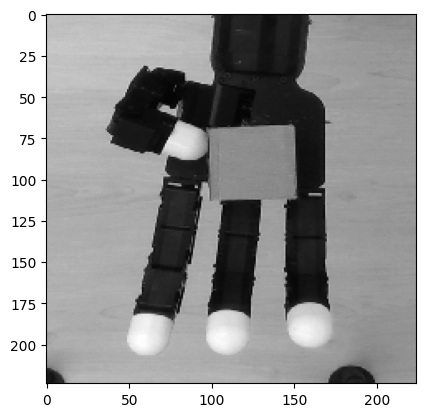

In [16]:
import matplotlib.pyplot as plt

for (img0, img1, img2, depth, field_id), Y in train_dataloader:
    print(depth[1].squeeze().shape)
    print(img0[0].shape)
    # plt.imshow(img2[20].squeeze().permute(1, 2, 0))
    plt.imshow(img0[0].squeeze(), cmap='gray')
    # plt.imshow(depth[0][2].squeeze())
    plt.show()
    break

plt.show()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train with CNN
Define a convolutional neural network with the following architecture.

```
Conv(
)

FC(
)
```

In [18]:
# AlexNet architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(conv_feature * 6 * 6, fc_feature)
        self.fc2 = nn.Linear(fc_feature, fc_feature)
        self.fc3 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = self.relu(self.conv4(x))
        # print(x.shape)
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.avgpool(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        # x = self.log_softmax(x)
        return x

In [123]:
# another simple architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_features, fc_features, output_size):
        super().__init__()
        # initial size is (3, 224, 224)
        self.conv1 = nn.Conv2d(9, 64, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(64, 96, kernel_size=5, padding=0)
        self.conv3 = nn.Conv2d(96, 64, kernel_size=3, padding=0)


        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(1024, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 12)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x
        

In [19]:
def train(epoch, model, optimizer):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(train_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        # send target to device
        target = target.to(device)
        # data, target = img0.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        # l1 loss
        # loss = nn.L1Loss()(output.float(), target.float() * 1000.0)

        # mseloss
        loss = nn.MSELoss()(output.float(), target.float() * 1000.0)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))

In [20]:
# test the model
def test(model):
    model.eval()
    test_loss = 0

    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(test_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        target = target.to(device)

        pred = model(data)

        rmse = torch.sqrt(nn.MSELoss()(pred.float(), target.float() * 1000.0))
        test_loss += rmse.item()

    test_loss /= len(test_dataloader.dataset)
    print('Test set: Average RMSE: {:.5f}'.format(test_loss))

        
    

In [21]:
# Training settings 
# number of feature maps
conv_features = 256
# number of input channels
input_channels = 6
fc_features = 4096
output_size = 12

# optimal lr
# lr = 0.0001

# test lr
lr = 0.0001

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr = lr) # create optimizer

# lr scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  
# optimizer = optim.SGD(params = model_cnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
# print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 20):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)
    # scheduler.step()

Train Epoch: 0 [0/2716 (0%)]	Loss: 4239.631348
Train Epoch: 0 [640/2716 (23%)]	Loss: 1336.201904
Train Epoch: 0 [1280/2716 (47%)]	Loss: 658.067383
Train Epoch: 0 [1920/2716 (70%)]	Loss: 885.338562
Train Epoch: 0 [2560/2716 (93%)]	Loss: 596.037842
Test set: Average RMSE: 0.21858
Train Epoch: 1 [0/2716 (0%)]	Loss: 587.682983
Train Epoch: 1 [640/2716 (23%)]	Loss: 495.933441
Train Epoch: 1 [1280/2716 (47%)]	Loss: 674.360229
Train Epoch: 1 [1920/2716 (70%)]	Loss: 550.091797
Train Epoch: 1 [2560/2716 (93%)]	Loss: 523.808777
Test set: Average RMSE: 0.20280
Train Epoch: 2 [0/2716 (0%)]	Loss: 461.305389
Train Epoch: 2 [640/2716 (23%)]	Loss: 522.792358
Train Epoch: 2 [1280/2716 (47%)]	Loss: 526.553528
Train Epoch: 2 [1920/2716 (70%)]	Loss: 578.138184
Train Epoch: 2 [2560/2716 (93%)]	Loss: 503.717377
Test set: Average RMSE: 0.20188
Train Epoch: 3 [0/2716 (0%)]	Loss: 558.006592
Train Epoch: 3 [640/2716 (23%)]	Loss: 556.299316
Train Epoch: 3 [1280/2716 (47%)]	Loss: 553.110046
Train Epoch: 3 [1920/2

In [22]:
test(model_cnn)

Test set: Average RMSE: 0.07369


In [23]:
test_dataset = LazyLoadDataset('./lazydata/', train = False, transform = transform_with_normalization)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [11]:
# predict
def predict(model):
    model.eval()
    pred = []
    for i, ((img0, img1, img2, depth, field_id)) in enumerate(test_dataloader):
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        output = model(data)
        # print(output)
        pred.append(output.cpu().detach().numpy())
    return np.concatenate(pred) / 1000.0

In [12]:
predict(model_cnn)

array([[ 0.04260449,  0.05248722,  0.12111972, ...,  0.06276813,
         0.04001951, -0.02848843],
       [ 0.04068422,  0.05299736,  0.12302349, ...,  0.05628278,
         0.04374341, -0.02920469],
       [ 0.05611328,  0.04687389,  0.09905244, ...,  0.04615065,
         0.03231372, -0.03750097],
       ...,
       [ 0.03295758,  0.0542848 ,  0.130284  , ...,  0.0511679 ,
         0.01688966, -0.06481688],
       [ 0.04262938,  0.05238463,  0.12117314, ...,  0.06568577,
         0.0282242 , -0.04039713],
       [ 0.04030341,  0.05229302,  0.12252476, ...,  0.04434344,
         0.04923514, -0.03103393]], dtype=float32)

In [24]:
import pandas as pd

def predict(model):
    outfile = 'submission.csv'
    output_file = open(outfile, 'w')
    titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
    
    model.eval()
    pred = []
    file_ids = []

    for i, ((img0, img1, img2, depth, field_id)) in enumerate(test_dataloader):
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        output = model(data)
        print(output)
        # output = output.cpu().detach().numpy()
        pred.append(output.cpu().detach().numpy())
        file_ids.extend(field_id)
        # file_ids = np.array(field_id)
    
    pred = np.concatenate(pred) / 1000.0
    print(pred)
    # pred = pred.flatten()
    # print('t1: ' + np.array(pred).shape)
    # print(np.array(field_id).shape)

    # pred = np.array(pred)
    df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(pred)], axis = 1, names = titles)
    df.columns = titles
    df.to_csv(outfile, index = False)
    print("Written to csv file {}".format(outfile))

In [25]:
predict(model_cnn)

tensor([[ 39.4098,  54.6678, 129.0238,  ...,  60.4348,  57.5257,  -5.6822],
        [ 56.4753,  54.5123, 123.9500,  ...,  74.1804,  56.5429, -43.1879],
        [ 73.3425,  48.2148,  93.2332,  ...,  46.2827,  71.6470, -15.1701],
        ...,
        [ 36.6323,  58.1380, 138.7348,  ...,  63.0810,  65.8977, -18.7232],
        [ 62.5217,  55.8433, 124.2576,  ...,  61.0954,  29.4378, -17.5398],
        [ 76.3028,  50.6186,  98.3142,  ...,  51.4960,  84.5721, -17.5874]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 41.3538,  53.7039, 127.1904,  ...,  50.1373,  22.3490, -47.8677],
        [ 61.6559,  53.2146, 118.4174,  ...,  48.1277,  28.8840, -25.0937],
        [ 45.0246,  55.4639, 129.7905,  ...,  60.6508,  53.1973,  -2.0569],
        ...,
        [ 65.2464,  52.1250, 111.5129,  ...,  61.9444,  32.4133, -56.3452],
        [ 74.1953,  51.5193, 104.7022,  ...,  50.7490,  50.4119, -11.8816],
        [ 40.8550,  56.3422, 133.8848,  ...,  65.0351,   1.0972, -68.1083]],
       dev